# Dirac DCT Dictionaries

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/carnotresearch/cr-sparse/blob/master/docs/tutorials/dirac_dct_dictionaries.ipynb)


In this tutorial we will:

* Construct a DCT basis
* Construct a Dirac-DCT dictionary.
* Construct a signal which is a mixture of few
  impulses and a few sinusoids.
* Construct its representation in the DCT basis.
* Recover its representation in Dirac-DCT dictionary
  using following sparse recovery algorithms
  
  * Orthogonal Matching Pursuit

* Measure the recovery error for different sparse
  recovery algorithms.


In [1]:
# Make sure that cr-sparse package is available on colab
!python -m pip install --quiet git+https://github.com/carnotresearch/cr-sparse.git

     |████████████████████████████████| 61kB 4.9MB/s 


We use JAX for numerical computations. Importing JAX dependencies:

In [3]:
import jax
import jax.numpy as jnp

Importing relevant modules from the CR-Sparse library:

In [4]:
import cr.sparse as crs
import cr.sparse.dict as dict
import cr.sparse.pursuit as pursuit

We will use `matplotlib` for all visualizations in this notebook.

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [6]:
%matplotlib inline

We will be working with signals in the space $\mathbb{R}^M$. The dimension of signal space:

In [2]:
M = 256

The standard basis or identity basis or Dirac basis for the signal space $I \in \mathbb{R}^{M \times M}$ can be easily constructed using JAX: 

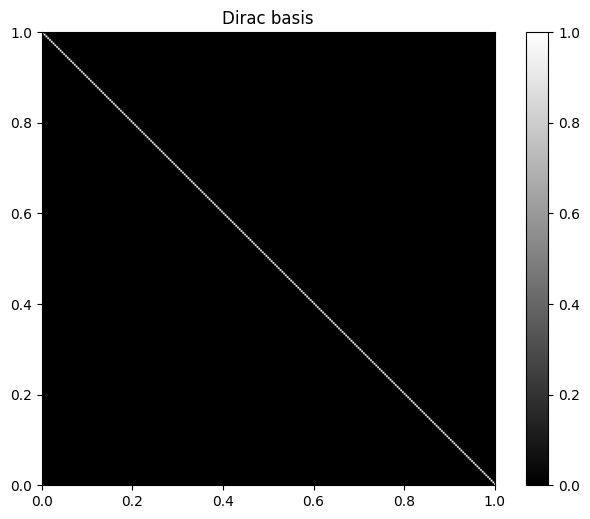

In [34]:
I = jnp.eye(M)
fig=plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(I, extent=[0, 1, 0, 1])
plt.gray()
plt.colorbar()
plt.title(r'Dirac basis');

## DCT basis construction

In [8]:
Psi = dict.dct_basis(M)
Psi.shape

(256, 256)

Visualizing the DCT basis

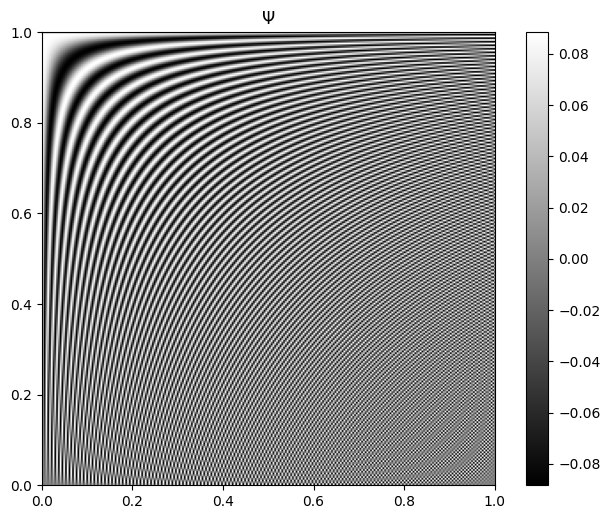

In [10]:
fig=plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(Psi, extent=[0, 1, 0, 1])
plt.gray()
plt.colorbar()
plt.title(r'$\Psi$');

## Dirac-DCT dictionary construction

A Dirac-DCT dictionary is a concatenation of the two orthonormal bases (the Dirac basis and the DCT basis). A simple way to do the same using Jax is: 

In [38]:
jnp.hstack([I, Psi]);

CR-Sparse provides a ready-made method for constructing a Dirac-DCT dictionary for $\mathbb{R}^M$:

In [11]:
Phi = dict.dirac_dct_basis(M)

As expected, the number of atoms in this dictionary is twice of $M$:

In [12]:
Phi.shape

(256, 512)

In [39]:
N = Phi.shape[1]
N

512

We can say that the dictionary $\Phi$ maps representations in $\mathbb{R}^N$ to signals in $\mathbb{R}^M$. $\mathbb{R}^N$ is called the representation space and $\mathbb{R}^M$ is called the signal space.

Visualizing the Dirac-DCT dictionary:

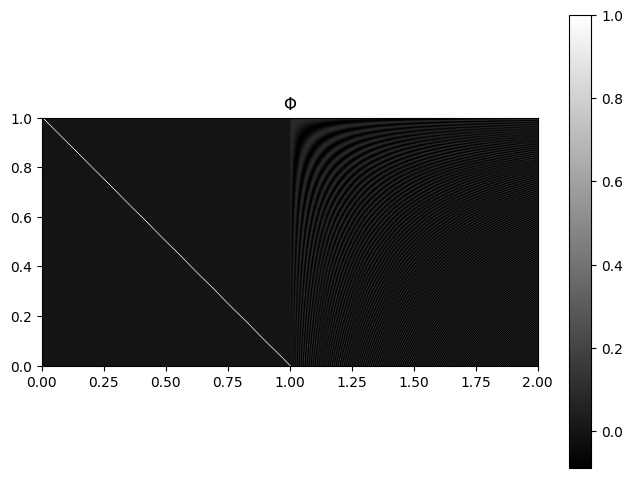

In [14]:
fig=plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(Phi, extent=[0, 2, 0, 1])
plt.gray()
plt.colorbar()
plt.title(r'$\Phi$');

## A mixture signal of impulses and sinusoids

We can combine some of the atoms from the Dirac basis and some of the atoms from the DCT basis, alternatively, some atoms from Dirac-DCT dictionary to form a signal which is a mixture of impulses and sinusoids. The atoms from Dirac basis contribute the impulses and the atoms from the Dirac basis contribute the sinusoids. 

In [40]:
x = crs.build_signal_from_indices_and_values(N, [20, 30, 100, M+3, M+57], [1, -0.4, 0.6, 1.2, -0.8])
y = Phi @ x

Visualizing the mixture signal

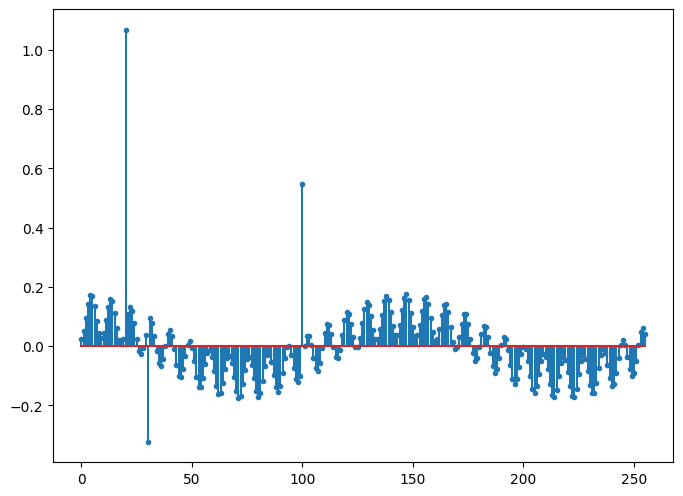

In [41]:
fig=plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
plt.stem(y, markerfmt='.', use_line_collection=True);

Notice the three impulses. The periodic component is coming from the two sinusoids.

$x$ in the equation $y = \Phi x$ above is the sparse representation of $y$ in the dictionary $\Phi$. It is called a sparse representation as it consists of very few non-zero values corresponding to the atoms which contribute in the construction of $y$. CR-Sparse provides some convenient functions to extrat the non-zero indices and non-zero values of a sparse representation.

The support $I$ of the representation $x$:

In [42]:
crs.nonzero_indices(x)

DeviceArray([ 20,  30, 100, 259, 313], dtype=int32)

The non-zero entries in $x$ over $I$ a.k.a. $x_I$:

In [43]:
crs.nonzero_values(x)

DeviceArray([ 1. , -0.4,  0.6,  1.2, -0.8], dtype=float32)

We remind that we can write $y = \Phi x$ as $y = \Phi_I x_I$ too as atoms with zero contribution in $y$ can be removed from the computation.

## Mixture signal representation in DCT basis

The representation of a signal $y$ in an orthogonal basis $\Psi$ is constructed by computing $\Psi^T y$. Let's see how does our $y$ fare in the DCT basis:

In [44]:
y_dct = Psi.T @ y

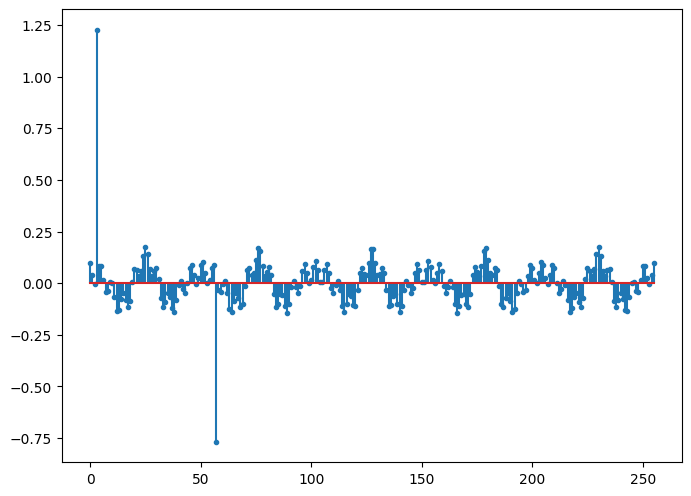

In [45]:
fig=plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
plt.stem(y_dct, markerfmt='.', use_line_collection=True);

We can see that there are two impulses in the DCT basis representation of $y$ which correspond to the sinusoids present in $y$. However, it also consists of a mix of sinusoids which are the representation of the impulses in $y$ in the DCT basis. Thus, the representation of $y$ in the DCT basis $\Psi$ is not sparse. In fact, $y$ doesn't have a sparse representation in any orthonormal basis for $\mathbb{R}^M$.

## Building a sparse representation in the Dirac DCT basis

Constructing the representation of $y$ in a dictionary is a non-trivial problem as it is an overcomplete set of atoms. There are infinite possible representations of $y$ in $\Phi$. However, under suitable conditions, the sparse representation of $y$ in $\Phi$ is unique. Also, under suitable conditions, there exist algorithms which can recover the sparse representation of $y$ in $\Phi$. 

One class of algorithms is called greedy pursuit algorithms. A representative in this class is Orthogonal Matching Pursuit (OMP). In order to run this algorithm, it is imperative that we are aware of the number of non-zero entries in the sparse representation (a.k.a. the sparsity of the representation of $y$ in $\Phi$). Fortunatley, in this example, we know this trivially:

In [46]:
K = crs.nonzero_indices(x).size
K

5

CR-Sparse provides a ready-made implementation of OMP. Let's import the module which provides this functionality. 

In [25]:
import cr.sparse.pursuit.omp

Running the OMP sparse recovery algorithm:

In [47]:
solution = pursuit.omp.solve(Phi, y, K)

In order to save space, the algorithm returns the nonzero values and their indices in the sparse representation:

The values at non-zero entries in the representation $x_I$:

In [28]:
solution.x_I

DeviceArray([ 1.1999999 ,  1.        , -0.7999999 ,  0.59999996,
             -0.39999998], dtype=float32)

The indices of non-zero entries $I$:

In [29]:
solution.I

DeviceArray([259,  20, 313, 100,  30], dtype=int32)

Note that the indices as identified by OMP may not be in the same order as earlier. The order of indices doesn't matter.

CR-Sparse provides a convenient function to combine the non-zero indices and values to form the overall sparse representation in $\mathbb{R}^N$.

In [30]:
z = crs.build_signal_from_indices_and_values(N, solution.I, solution.x_I)

Visualizing the representation:

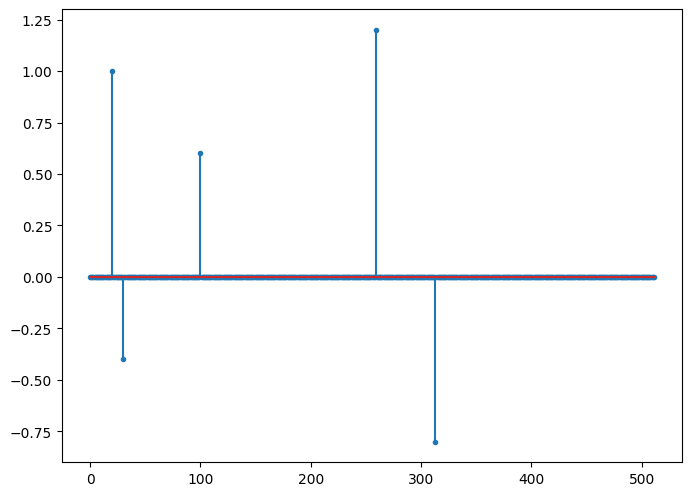

In [31]:
fig=plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
plt.stem(z, markerfmt='.', use_line_collection=True);

## Sparse representation error

In general, OMP may be fed a signal $y = \Phi x + e$ where $e$ is the sparse representation error. When OMP estimates $x$ is actually computes an approximation $\hat{x}$. It also estimates a residual $r = y - \Phi \hat{x}$.

The energy of the residual is given by:

In [27]:
solution.r_norm_sqr

DeviceArray(3.802608e-14, dtype=float32)

In this case, the energy of residual is very small as there was no representation error in the original computation $y = \Phi x$. This residual energy corresponds to floating point computation errors.

Visualizing the residual:

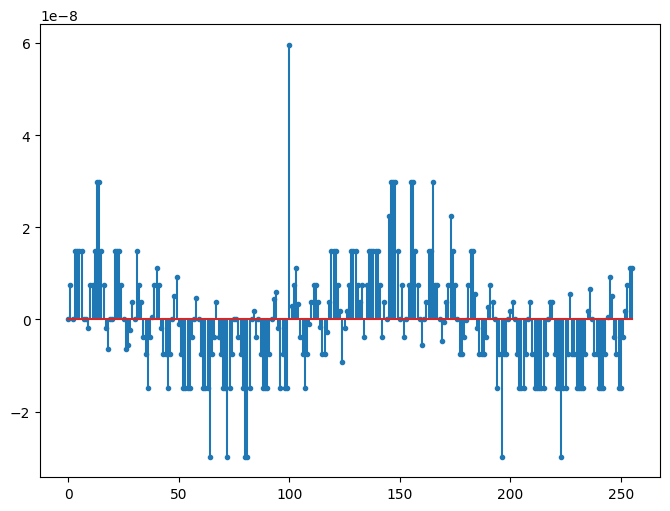

In [32]:
fig=plt.figure(figsize=(8,6), dpi= 100, facecolor='w', edgecolor='k')
plt.stem(solution.r, markerfmt='.', use_line_collection=True);